# **LSTM Forecast - Reservoir Levels**


---



## **Libraries**

In [ ]:
#%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import math

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

## **Load Data**

The data was obtained from 2 sources:
1.   Watercare Services Limited
2.   NIWA

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_UN= pd.read_csv('gdrive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_M= pd.read_csv('gdrive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
df_W= pd.read_csv('gdrive/My Drive/DL Project/Waitakere/Waitakere_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
df_orig = df_M #select site

In [ ]:
if df_orig is df_UN:
  site = 'Upper Nihotupu'
elif df_orig is df_M:
  site = 'Mangatangi'
elif df_orig is df_W:
  site = 'Waitakere'

In [ ]:
shift_steps = 30 

In [ ]:
#df= pd.read_csv('gdrive/My Drive/DL Project/Mangatangi/Mangatangi_All.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True
#df_orig = pd.read_csv('gdrive/My Drive/DL Project/Upper Niho/Upper_Niho_Clean.csv', index_col=0, parse_dates=['Date'], dayfirst=True)#, squeeze=True

In [ ]:
#df_orig.drop(['Rainfall (NiWa)', 'Vapour Pressure (hPa)', 'Max Temp' ], axis=1, inplace=True)

In [ ]:
df_val = df_orig[-(365+shift_steps):]

In [ ]:
y_val = df_val['Level'].shift(-shift_steps)
y_val = y_val[:-shift_steps]

In [ ]:
df_val = df_val[:-shift_steps]

In [ ]:
df = df_orig[:-(365+shift_steps)]

Interpolating to handle missing values:

In [ ]:
df.isnull().sum()

Level                 0
Spill                 0
Rainfall (WSL)        0
Abstraction           0
Compensation          0
Rainfall (NIWA)       0
Soil Moisture         0
Max Temp              0
Penman Evaporation    0
Vapour Pressure       0
Solar Radiation       0
Year sin              0
Year cos              0
dtype: int64

In [ ]:
df

,Level,Spill,Rainfall (WSL),Abstraction,Compensation,Rainfall (NIWA),Soil Moisture,Max Temp,Penman Evaporation,Vapour Pressure,Solar Radiation,Year sin,Year cos
Date,,,,,,,,,,,,,
2009-01-01,52.137,0.0,2.35,124727.625,15000.000,2.5,-77.3,25.5,3.2,21.2,14.8,0.0172,0.9999
2009-01-02,52.094,0.0,7.99,125076.500,15000.000,11.2,-72.4,25.1,4.5,20.8,16.6,0.0344,0.9994
2009-01-03,52.057,0.0,13.63,124547.250,15000.000,0.0,-77.4,21.9,6.0,12.5,31.9,0.0516,0.9987
2009-01-04,52.013,0.0,0.00,125002.000,15000.000,0.0,-81.4,22.7,5.1,14.1,28.4,0.0688,0.9976
2009-01-05,51.958,0.0,0.00,125034.875,15000.000,0.0,-84.6,22.9,5.5,15.0,29.9,0.0859,0.9963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-17,47.196,0.0,0.00,105117.000,22896.250,0.0,-145.6,26.8,4.2,19.3,19.1,0.7350,0.6780
2020-02-18,47.127,0.0,0.00,102540.875,22893.750,0.0,-144.7,27.1,4.3,21.4,16.3,0.7466,0.6653
2020-02-19,47.055,0.0,3.80,99224.625,23955.625,0.0,-145.0,28.5,5.4,17.9,27.2,0.7579,0.6523


In [ ]:
df.values.shape

(4069, 13)

### **Target**

The output we want to predict

In [ ]:
target = ['Level']

Shifting the target column to the number of steps ahead we want to forecast

In [ ]:
df_targets = df[target].shift(-shift_steps)

In [ ]:
df_targets.head()

,Level
Date,
2009-01-01,50.724
2009-01-02,50.665
2009-01-03,50.606
2009-01-04,50.537
2009-01-05,50.472


### **NumPy Array**



1.   Converting to NumPy array to feed into the neural network.
2.   Removing the 'NaN' values due to the shift.
3.   Train/test split









Input data

In [ ]:
x_data = df.values[0:-shift_steps]

In [ ]:
x_data.shape

(4039, 13)

In [ ]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (4039, 13)


Output data

In [ ]:
y_data = df_targets.values[:-shift_steps]

In [ ]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (4039, 1)


Number of observations/rows in the dataset

In [ ]:
num_data = len(x_data)
num_data

4039

Train/test fraction

In [ ]:
train_split = 0.85

Number of training and testing samples

In [ ]:
num_train = int(train_split * num_data)
num_test = num_data - num_train

print (f'Number of training samples: {num_train}')
print (f'Number of test samples: {num_test}')

Number of training samples: 3433
Number of test samples: 606


Input-signals for the training- and test-sets:

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

4039

In [ ]:
x_train.shape

(3433, 13)

Output-signals for the training- and test-sets:

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

4039

Number of input features

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

13

Number of output signals

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

1

### **Data Scaling**

Range of values from the dataset

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -142.0
Max: 135859.625


Creating a scaler object for the inputs

In [ ]:
x_scaler = MinMaxScaler() #scaling data between 0 & 1

Scaling the training input data

In [ ]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [ ]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


Scaling the testing input data

In [ ]:
x_test_scaled = x_scaler.transform(x_test)

Scaling the output/target data. Note a separate scaling object (y_scaler) is created.

In [ ]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## **Data Generator**

The data has now been prepared as 2D NumPy arrays. 

In [ ]:
print(f'X Train Shape: {x_train_scaled.shape}')
print(f'Y Train Shape: {y_train_scaled.shape}')

X Train Shape: (3433, 13)
Y Train Shape: (3433, 1)


In [ ]:
print(f'X Test Shape: {x_test_scaled.shape}')
print(f'Y Test Shape: {y_test_scaled.shape}')

X Test Shape: (606, 13)
Y Test Shape: (606, 1)


A batch_generator function is used to create a batch of shorter sub-sequences picked at random from the training-data. 

In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Defining batch size

In [ ]:
batch_size = 20

Defining sequence length. Number of observations per batch

In [ ]:
sequence_length = 365

Assigning generator function

In [ ]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Testing the batch-generator

In [ ]:
x_batch, y_batch = next(generator)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

(20, 365, 13)
(20, 365, 1)


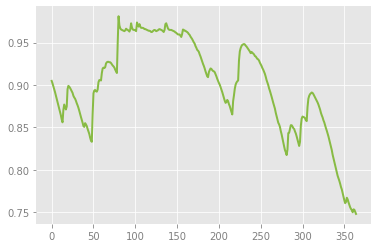

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 13 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

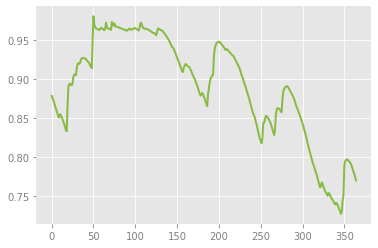

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### **Validation Set**

To overcome the risk of overfitting, the performance is monitored on the test set after each epoch and the models weights are saved only if the performance is improved on the test set. 


The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
re, er = validation_data

In [ ]:
re.shape

(1, 606, 13)

In [ ]:
er.shape

(1, 606, 1)

## **Gated Recurrent Unit (GRU)**

Recurrent Neural Network (RNN) is created using the Keras API.

**1st Hidden layer:**

The GRU will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by None), where each observation has a number of input-signals (num_x_signals).

**Dense layer:**

A fully-connected (or dense) layer is then added which maps 512 values down to only 1 value.

**Activation Function:**

A linear activation function is used on the output so that the output values can take on arbitary values and, unlike a sigmoid activation function, which maps outputs between 0 and 1, the linear activation output is not constrained by the values of the training data. 

In [ ]:
from tensorflow.python.keras.initializers import RandomUniform

init = RandomUniform(minval=-0.05, maxval=0.05)

In [ ]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(None, num_x_signals)))#activation='relu',
#model.add(LSTM(50, activation='relu'))
model.add(Dense(num_y_signals, 
                activation='linear',
                kernel_initializer=init))

#model.add(GRU(units=512,
              #return_sequences=True,
              #input_shape=(None, num_x_signals)))


In [ ]:
from tensorflow.python.keras.initializers import RandomUniform

init = RandomUniform(minval=-0.05, maxval=0.05)

#model.add(Dense(num_y_signals, 
                #activation='linear',
                #kernel_initializer=init))
#if False:
  #from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    #init = RandomUniform(minval=-0.05, maxval=0.05)

    #model.add(Dense(num_y_signals,
                    #activation='linear',
                    #kernel_initializer=init))



### **Loss Function**

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [ ]:
warmup_steps = 50

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse



### **Compile Model**

Optimizer

In [ ]:
#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3)

Compile the Keras model so it is ready for training.

In [ ]:
#model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 512)         1077248   
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           513       
Total params: 1,077,761
Trainable params: 1,077,761
Non-trainable params: 0
_________________________________________________________________


### **Callback Functions**

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=20, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=1,
                                   write_graph=True)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## **Training the Recurrent Neural Network**

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected steps_per_epoch 

In [ ]:
%%time
validation = model.fit(x=generator,
          epochs=100,
          steps_per_epoch=30,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100
30/30 [==============================] - 4s 71ms/step - loss: 0.0578 - val_loss: 0.0066

Epoch 00001: val_loss improved from inf to 0.00661, saving model to 23_checkpoint.keras
Epoch 2/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0060 - val_loss: 0.0046

Epoch 00002: val_loss improved from 0.00661 to 0.00456, saving model to 23_checkpoint.keras
Epoch 3/100
30/30 [==============================] - 1s 32ms/step - loss: 0.0047 - val_loss: 0.0053

Epoch 00003: val_loss did not improve from 0.00456

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
30/30 [==============================] - 1s 33ms/step - loss: 0.0045 - val_loss: 0.0042

Epoch 00004: val_loss improved from 0.00456 to 0.00421, saving model to 23_checkpoint.keras
Epoch 5/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0044 - val_loss: 0.0046

Epoch 00005: val_loss did not improve from 0.00421

Epoch 00005: ReduceLROnPlateau reducin

**Load Checkpoint**

Because early-stopping was used when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### **Model Performance on Test Set**

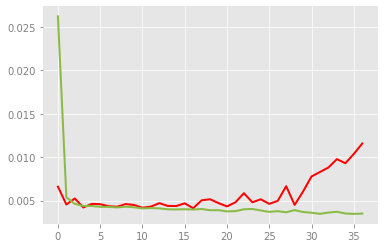

In [ ]:
plt.plot(validation.history['val_loss'], 'r', validation.history['loss'])

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 34ms/step - loss: 0.0041


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.004129422828555107


In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))



---



## **Results**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
x = x_test_scaled
y_true = y_test

In [ ]:
start_idx = 0
length = 3000

In [ ]:
end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

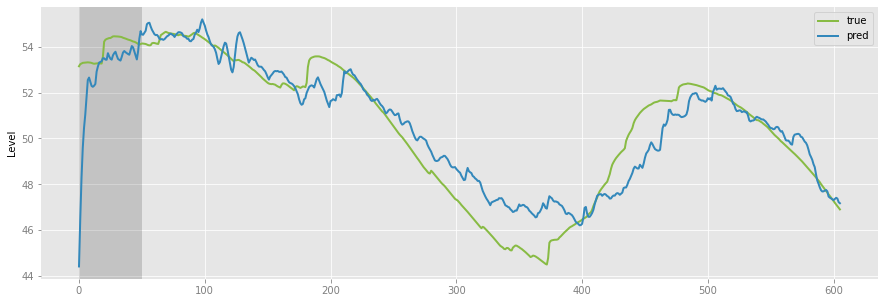

In [ ]:
for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')

        result_table = pd.DataFrame(signal_true)
        result_table['pred'] = pd.DataFrame(signal_pred)
    
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

        #MAE and MSE
        mae = mean_absolute_error(signal_true[10:],signal_pred[10:])
        mse = mean_squared_error(signal_true[10:],signal_pred[10:])
        rmse = math.sqrt(mean_squared_error(signal_true[10:], signal_pred[10:]))
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()

### **Plotting Entire Dataset (Train, Test and Predictions)**

In [ ]:
x1 = x_train_scaled
y_true1 = y_train

No handles with labels found to put in legend.


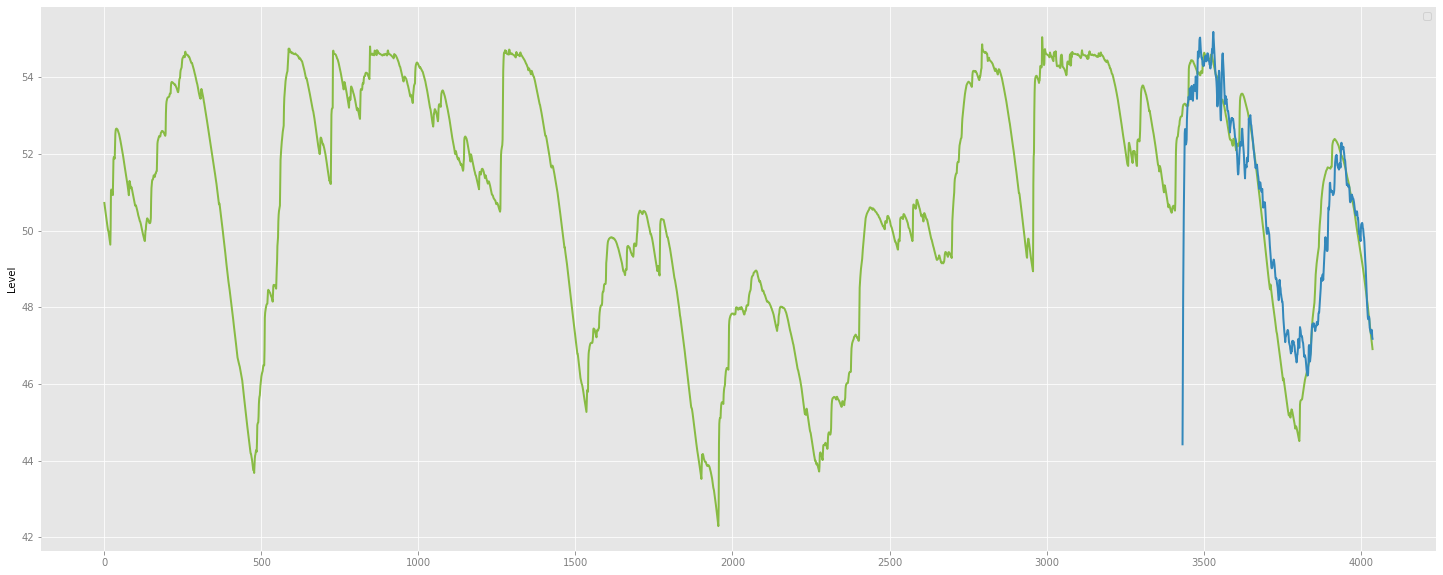

In [ ]:
# For each output-signal.
for signal in range(len(target)):
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true1[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(25,10))
    
    # Plot and compare the two signals.
    plt.ylabel(target[signal])
    plt.legend()
    plt.plot(y_data, label='true')
    plt.plot([None for x in y_true1] + [x for x in signal_pred], label='pred')
    plt.show()


### **Evaluating forecast accuracy**

Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

In [ ]:
print(f'mean absolute error {mae}')
print(f'mean squared error {mse}')
print (f'root mean squared error {rmse}')

mean absolute error 0.7927377686468544
mean squared error 1.0698326935516145
root mean squared error 1.034327169493103




---



# **Saving and Running Model**

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(f"GRU_Mangatangi_{shift_steps}Day.h5")

In [ ]:
model_2 = load_model(f'/content/GRU_Mangatangi_{shift_steps}Day.h5', compile=False)

In [ ]:
x_test2 = df_val.values

In [ ]:
x_test2_scaled = x_scaler.transform(x_test2)

In [ ]:
x2 = x_test2_scaled    
    # Input-signals for the model.
x2 = np.expand_dims(x2, axis=0)

In [ ]:
x2.shape

(1, 365, 13)

In [ ]:
y_pred2 = model.predict(x2)
#y_pred2 = model.predict(x2)

In [ ]:
y_pred_rescaled2 = y_scaler.inverse_transform(y_pred2[0])

In [ ]:
result_df = pd.DataFrame(y_val)

In [ ]:
result_df['pred'] = y_pred_rescaled2

In [ ]:
result_df

,Level,pred
Date,,
2020-02-22,44.634,44.689846
2020-02-23,44.559,46.478146
2020-02-24,44.479,47.584881
2020-02-25,44.394,48.063538
2020-02-26,44.311,48.009907
...,...,...
2021-02-16,43.938,43.685638
2021-02-17,43.887,43.750893
2021-02-18,43.851,43.899899


<Figure size 864x576 with 0 Axes>

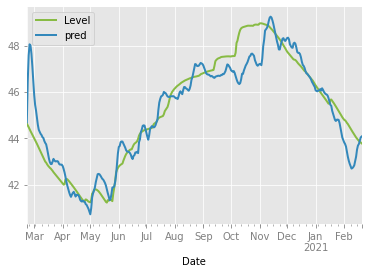

In [ ]:
plt.figure(figsize=(12,8))
result_df.plot()

In [ ]:
result_df['year'] = result_df.index.year
result_df['month'] = result_df.index.month

In [ ]:
month_n = 12
df_month = result_df.groupby('month')

In [ ]:
error_df = pd.DataFrame()
rmse_list = []
mse_list = []
mae_list = []
for i in range(1,13):
  rmse_month = math.sqrt(mean_squared_error(df_month.get_group(i)['Level'], df_month.get_group(i)['pred']))
  #mse_month = mean_squared_error(df_month.get_group(i)['Level'], df_month.get_group(i)['pred'])
  mae_month = mean_absolute_error(df_month.get_group(i)['Level'], df_month.get_group(i)['pred'])

  rmse_list.append(rmse_month)
  #mse_list.append(mse_month)
  mae_list.append(mae_month)
  error_df = pd.DataFrame(rmse_list, columns=['RMSE'])
  #error_df['MSE'] = mse_list
  error_df['MAE'] = mae_list


In [ ]:
error_df

,RMSE,MAE
0,0.431291,0.361704
1,1.816835,1.466847
2,0.823573,0.747518
3,0.334369,0.269984
4,0.505568,0.413887
5,0.497815,0.398873
6,0.475458,0.357804
7,0.419168,0.399703
8,0.524489,0.459739
9,1.576599,1.501487


In [ ]:
#mse = mean_squared_error(y_val[10:], y_pred_rescaled2[10:])
rmse = math.sqrt(mean_squared_error(y_val[10:], y_pred_rescaled2[10:]))
mae = mean_absolute_error(y_val[10:], y_pred_rescaled2[10:])
#print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.7190655696942676
MAE: 0.5423024647027674


Text(0, 0.5, 'Error')

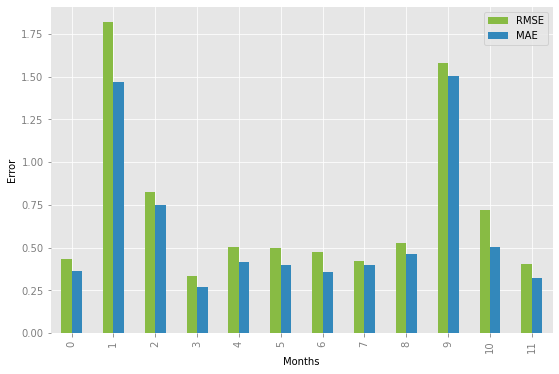

In [ ]:
# Plot a bar chart using the DF
ax_errors = error_df.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig_errors = ax_errors.get_figure()
# Change the plot dimensions (width, height)
fig_errors.set_size_inches(9, 6)
# Change the axes labels
ax_errors.set_xlabel("Months")
ax_errors.set_ylabel("Error")

# **Plotting**

In [ ]:
from matplotlib import cycler
colors = cycler('color',['#88BB44', '#3388BB', '#9988DD',
                        '#EE6666', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [ ]:
train_final = df_orig[:num_train]
val_final = df_orig[num_train:-shift_steps]
orig_final = df_orig[-shift_steps:]

In [ ]:
orig_final = orig_final[['Level']]
train_final = train_final[['Level']]
val_final = val_final[['Level']]
test_final = df_val[['Level']]

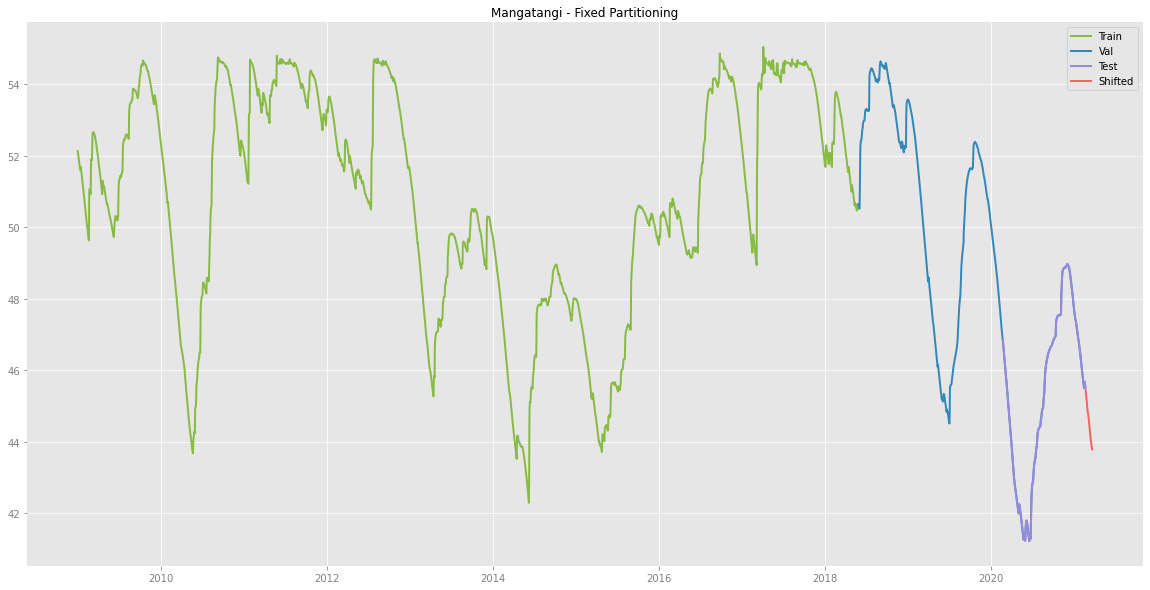

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_final.index, train_final, label = 'Train')
plt.plot(val_final.index, val_final, label = 'Val')
plt.plot(test_final.index, test_final,  label = 'Test')
plt.plot(orig_final.index, orig_final,  label = 'Shifted')
plt.legend(loc = 'best')
plt.title(f'{site} - Fixed Partitioning')

plt.show()

In [ ]:
print(f'Length train: {len(train_final)}')
print(f'Length val: {len(val_final)}')
print(f'Length test: {len(test_final)}')
print(f'Length discarded: {len(orig_final)}')

Length train: 3433
Length val: 1001
Length test: 365
Length discarded: 30


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir 23_logs/

Reusing TensorBoard on port 6006 (pid 689), started 0:02:58 ago. (Use '!kill 689' to kill it.)

<IPython.core.display.Javascript object>